# Self-supervised Vision Transformer for Land Cover Segmentation
### Pre-trained model with Swin Transformer and Sentinel-1/2, segmentation head trained with Flair1


In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
!git clone https://github.com/BertilleT/LandCover_map_Transformers_SSL.git

Cloning into 'LandCover_map_Transformers_SSL'...
remote: Enumerating objects: 8612, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 8612 (delta 64), reused 179 (delta 49), pack-reused 8417
Receiving objects: 100% (8612/8612), 423.77 MiB | 23.85 MiB/s, done.
Resolving deltas: 100% (499/499), done.


In [1]:
cd LandCover_map_Transformers_SSL/src

/content/LandCover_map_Transformers_SSL/src


## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

In [2]:
!pip install wandb
!pip install rasterio
!pip install timm
!pip install einops
!pip install diffdist

In [3]:
# Import needed packages
import json
import random
import numpy as np
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from ...tools.utils_Flair1 import *
from ...tools.metrics import PixelwiseMetrics
from ...Transformer_SSL.models import build_model
from ...Transformer_SSL.models.swin_transformer import SwinTransformerDecoder

In [4]:
import importlib
import utils_B
importlib.reload(utils_B)
from utils_B import *

### Quick Start
You can specify in the some hyperparameters in train_config (cell below), such as the learning_rate, the batch_size, number of epochs, or if you wish to fine-tune the model or not (with the finetuning argument), etc.

In [5]:
# Data configurations:
data_config = {
    'train_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/train', # path to the training directory,
    'val_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/val', # path to the validation directory,
    'test_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/test', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 13, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

In [6]:
# Ensure deterministic behavior
random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [7]:
#from dfc_dataset import DFCDataset
size = 224
multimodal = True
train_dataset = Flair1Dataset_SSL(data_config['train_dir'], size, multimodal)
val_dataset = Flair1Dataset_SSL(data_config['val_dir'], size, multimodal)
test_dataset = Flair1Dataset_SSL(data_config['test_dir'], size, multimodal)

We can see how many examples are in each split by checking their length:

In [8]:
len(train_dataset), len(val_dataset)

(1664, 416)

In [9]:
#loop on train_ds and check shape of rgb and ir_el
rgb = train_dataset[0][0]['rgb']
ir_el = train_dataset[0][0]['ir_el']
print(rgb.shape)
print(ir_el.shape)

torch.Size([3, 224, 224])
torch.Size([2, 224, 224])


We define a correspondance of label and names:

In [10]:
dict_classes_13 = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'other'}

Our data is now ready to be used by the model. In the next section we load and configure the model.

<a id='quickstart'></a>
## 3. Quick Start

#### Configure

You can specify in the some hyperparameters in `train_config` (cell below), such as the `learning_rate`, the `batch_size`, number of `epochs`, or if you wish to fine-tune the model or not (with the `finetuning` argument), etc.

In [11]:
# Training configurations
train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': False, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999),
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 60,
    'target': 'dfc_label'
}

#### Download checkpoint

You can download the pre-trained backbone model using this [link](https://drive.google.com/file/d/1e7QhC2-zoBFgb65yN1ADWBZLMShHOweY/view), save it in the `checkpoints/` directory then run the following cell.

Make sure to properly modify the path to the downloaded checkpoint in the path below.

In the case where you are using a uni-modal dataset (Sentinel-2 only or Sentinel-1 only), you can load the corresponding weight stream `s1_weights` or `s2_weights`, and comment the other one.

In [12]:
# path to the checkpoint
checkpoint = torch.load(
    "../../drive/MyDrive/MVA/swin_t.pth",#, map_location=torch.device('cpu') #comment map_location if using GPU
)
weights = checkpoint["state_dict"]

# Sentinel-1 stream weights
s1_weights = {
    k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k
}

# Sentinel-2 stream weights
s2_weights = {
    k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k
}

#### Prepare model and load checkpoint

We prepare the model by specifying the `input_channels`: only sentinel1, only sentinel2 or both. We also specify if we need both backbones `s1_backbone` and `s2_backbone` depending on our application. In the case where only one stream is needed, just comment the lines `s1_backbone` or `s2_backbone`.

In [13]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def dotdictify(d):
    """recursively wrap a dictionary and
    all the dictionaries that it contains
    with the dotdict class
    """
    d = dotdict(d)
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = dotdictify(v)
    return d

In [14]:
#from utils_SSL import save_checkpoint_single_model, dotdictify

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

# Input channel size
# input_channels = 3#train_config['s1_input_channels'] + train_config['s2_input_channels']

# If you are using a uni-modal dataset, you can un-comment one of these lines, and comment the one above:
# input_channels = train_config['s1_input_channels']
# input_channels = train_config['s2_input_channels']

with open("configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)

swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)

s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

We create the downstream model head that will be trained. In this demo, we will train a classifier. You can find a segmentation head in the repository (/TransformerSSL/models/swin_transformer/DoubleSwinTransformerSegmentation). Our classifier takes as input the pre-trained backbone (in the form of two streams `encoder1` and `encoder2`), the `out_dim` (number of classes), and `freeze_layers` flag, specifying whether you wish to freeze the backbone weights or not.

In [26]:
class DoubleSwinTransformerSegmentation(nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=False):
        super(DoubleSwinTransformerSegmentation, self).__init__()

        self.device = device

        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.decoder1 = SwinTransformerDecoder(self.backbone1, out_dim, device)
        self.decoder2 = SwinTransformerDecoder(self.backbone2, out_dim, device)

        # freeze all backbone layers
        if freeze_layers:
            for name, param in self.named_parameters():
                if name.startswith(('backbone')):
                    param.requires_grad = False

        self.expand_channels = torch.nn.Conv2d(3, 13, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        expanded_rgb = self.expand_channels(x["rgb"].to(self.device))
        _, x2, x_seg2 = self.backbone2.forward_features(expanded_rgb)

        _, x1, x_seg1 = self.backbone1.forward_features(x["ir_el"].to(self.device))

        x1 = self.decoder1.forward_up_features(x1, x_seg1)
        x2 = self.decoder2.forward_up_features(x2, x_seg2)

        x = torch.cat([x1, x2], dim=-1)

        output = self.decoder1.up_x4(x)

        return output

In [27]:
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device
    )

model = model.to(device)

Define and initialise the loss for training. Here we are training for single-class classification and using a `torch.nn.CrossEntropyLoss` loss.

In [28]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

Define the trainable parameters (needed for the optimizer):

In [29]:
if train_config['finetuning']:
    # train all parameters (backbone + classifier head)
    param_backbone = []
    param_head = []
    for p in model.parameters():
        if p.requires_grad:
            param_head.append(p)
        else:
            param_backbone.append(p)
        p.requires_grad = True
    # parameters = model.parameters()
    parameters = [
        {"params": param_backbone},  # train with default lr
        {
            "params": param_head,
            "lr": train_config['classifier_lr'],
        },  # train with classifier lr
    ]
    print("Finetuning")

else:
    # train only final linear layer for SSL methods
    print("Frozen backbone")
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

Frozen backbone


Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want.

In [30]:
optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader

In [31]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=train_config['dataloader_workers'],
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

Everything is set and we are now ready to train the segmentation head:

Epoch:20, Training Loss:0.9782: 100%|██████████| 104/104 [05:31<00:00,  3.19s/it]


{'train_loss': 0.9802197813987732, 'train_average_accuracy': 0.5189160377458987, 'train_mIoU': 0.4080607319390348, 'train_accuracy_pixelclass_0': 0.8002994283361525, 'train_accuracy_pixelclass_1': 0.19362160574098808, 'train_accuracy_pixelclass_2': 0.7927483830385563, 'train_accuracy_pixelclass_3': 0.1529721736098106, 'train_accuracy_pixelclass_4': 0.7837497442411703, 'train_accuracy_pixelclass_5': 0.5731918701591939, 'train_accuracy_pixelclass_6': 0.8570404112464771, 'train_accuracy_pixelclass_7': 0.4103914723570255, 'train_accuracy_pixelclass_8': 0.7968992991063757, 'train_accuracy_pixelclass_9': 0.7590781624039972, 'train_accuracy_pixelclass_10': 0.439339466557682, 'train_accuracy_pixelclass_11': 0.1865764738992537, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6134096987298362, 'train_IoU_class_1': 0.15680008858978872, 'train_IoU_class_2': 0.5691414559903577, 'train_IoU_class_3': 0.1527413645244282, 'train_IoU_class_4': 0.6919144673339109, 'train_IoU_class_5': 0.50237

Validation Loss:1.001: 100%|██████████| 26/26 [00:26<00:00,  1.03s/it]


Epoch:20 {'validation_loss': 1.0007444620132446, 'validation_average_accuracy': 0.5136576098766832, 'validation_mIoU': 0.3986757776834872, 'validation_accuracy_pixelclass_0': 0.7708568756772368, 'validation_accuracy_pixelclass_1': 0.3041938243441421, 'validation_accuracy_pixelclass_2': 0.749564073613877, 'validation_accuracy_pixelclass_3': 0.012036731849985188, 'validation_accuracy_pixelclass_4': 0.8106797553719944, 'validation_accuracy_pixelclass_5': 0.5341338066030373, 'validation_accuracy_pixelclass_6': 0.8436816003015625, 'validation_accuracy_pixelclass_7': 0.38410321028666344, 'validation_accuracy_pixelclass_8': 0.789553213746259, 'validation_accuracy_pixelclass_9': 0.6665231614136351, 'validation_accuracy_pixelclass_10': 0.46091323872284723, 'validation_accuracy_pixelclass_11': 0.35130943646564183, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5677548005798555, 'train_IoU_class_1': 0.1971397984870025, 'train_IoU_class_2': 0.5803615227033446, 'train_IoU_class_3'

Epoch:21, Training Loss:0.9484: 100%|██████████| 104/104 [05:30<00:00,  3.18s/it]


{'train_loss': 0.948063313961029, 'train_average_accuracy': 0.52932820736147, 'train_mIoU': 0.41835423081926465, 'train_accuracy_pixelclass_0': 0.8070377181379214, 'train_accuracy_pixelclass_1': 0.2076139441403106, 'train_accuracy_pixelclass_2': 0.7894512146276188, 'train_accuracy_pixelclass_3': 0.14765228959077317, 'train_accuracy_pixelclass_4': 0.7940854239264254, 'train_accuracy_pixelclass_5': 0.6152956436336784, 'train_accuracy_pixelclass_6': 0.854840602422453, 'train_accuracy_pixelclass_7': 0.4109308649750984, 'train_accuracy_pixelclass_8': 0.8253236139066552, 'train_accuracy_pixelclass_9': 0.7419228571753186, 'train_accuracy_pixelclass_10': 0.5162096706735414, 'train_accuracy_pixelclass_11': 0.1709028524893164, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6084148535704985, 'train_IoU_class_1': 0.16786934549227608, 'train_IoU_class_2': 0.5705407401377001, 'train_IoU_class_3': 0.14709053526534246, 'train_IoU_class_4': 0.7137310645332433, 'train_IoU_class_5': 0.539359

Validation Loss:1.033: 100%|██████████| 26/26 [00:26<00:00,  1.01s/it]


Epoch:21 {'validation_loss': 1.0327807664871216, 'validation_average_accuracy': 0.5056188292798759, 'validation_mIoU': 0.3960607060083006, 'validation_accuracy_pixelclass_0': 0.7163275054355674, 'validation_accuracy_pixelclass_1': 0.31688630438324916, 'validation_accuracy_pixelclass_2': 0.8457236661692756, 'validation_accuracy_pixelclass_3': 0.01075587338275973, 'validation_accuracy_pixelclass_4': 0.7927625947251282, 'validation_accuracy_pixelclass_5': 0.4983899965892208, 'validation_accuracy_pixelclass_6': 0.8012194463588511, 'validation_accuracy_pixelclass_7': 0.45003624930478203, 'validation_accuracy_pixelclass_8': 0.7528837403484412, 'validation_accuracy_pixelclass_9': 0.7131845982911228, 'validation_accuracy_pixelclass_10': 0.26987869376027845, 'validation_accuracy_pixelclass_11': 0.40499611188970946, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5837515327578119, 'train_IoU_class_1': 0.2055005409003911, 'train_IoU_class_2': 0.5563811782900309, 'train_IoU_class_

Epoch:22, Training Loss:0.9449: 100%|██████████| 104/104 [05:06<00:00,  2.95s/it]


{'train_loss': 0.9420670866966248, 'train_average_accuracy': 0.5366013164002202, 'train_mIoU': 0.42572471461272865, 'train_accuracy_pixelclass_0': 0.8021289267642433, 'train_accuracy_pixelclass_1': 0.22106540792032695, 'train_accuracy_pixelclass_2': 0.7891514935587185, 'train_accuracy_pixelclass_3': 0.16913459861933575, 'train_accuracy_pixelclass_4': 0.8053079463592193, 'train_accuracy_pixelclass_5': 0.6212235195473065, 'train_accuracy_pixelclass_6': 0.8554889030513249, 'train_accuracy_pixelclass_7': 0.41495944237641386, 'train_accuracy_pixelclass_8': 0.7965793766131045, 'train_accuracy_pixelclass_9': 0.7406785766479762, 'train_accuracy_pixelclass_10': 0.5194826355498554, 'train_accuracy_pixelclass_11': 0.24061628619503753, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6066472188483751, 'train_IoU_class_1': 0.1784197770449385, 'train_IoU_class_2': 0.5755374636938068, 'train_IoU_class_3': 0.1686373540334918, 'train_IoU_class_4': 0.7151664221332508, 'train_IoU_class_5': 0.5

Validation Loss:0.9949: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s]


Epoch:22 {'validation_loss': 0.9949438571929932, 'validation_average_accuracy': 0.4967062911489597, 'validation_mIoU': 0.38831513185428973, 'validation_accuracy_pixelclass_0': 0.758736544887739, 'validation_accuracy_pixelclass_1': 0.2710281896692195, 'validation_accuracy_pixelclass_2': 0.7834041595509486, 'validation_accuracy_pixelclass_3': 0.0018941685476233192, 'validation_accuracy_pixelclass_4': 0.7280257654923132, 'validation_accuracy_pixelclass_5': 0.414571542539354, 'validation_accuracy_pixelclass_6': 0.8414962827185957, 'validation_accuracy_pixelclass_7': 0.3962968433713511, 'validation_accuracy_pixelclass_8': 0.7775016652750284, 'validation_accuracy_pixelclass_9': 0.7461772357728518, 'validation_accuracy_pixelclass_10': 0.33304888187678144, 'validation_accuracy_pixelclass_11': 0.4050005052346705, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5821733062959539, 'train_IoU_class_1': 0.19026810609852005, 'train_IoU_class_2': 0.5808823555189552, 'train_IoU_class_3

Epoch:23, Training Loss:0.9155: 100%|██████████| 104/104 [05:23<00:00,  3.11s/it]


{'train_loss': 0.915687620639801, 'train_average_accuracy': 0.5404029532231985, 'train_mIoU': 0.42860538770906687, 'train_accuracy_pixelclass_0': 0.8092623062895313, 'train_accuracy_pixelclass_1': 0.23922837026150848, 'train_accuracy_pixelclass_2': 0.797005889465757, 'train_accuracy_pixelclass_3': 0.12006612723034103, 'train_accuracy_pixelclass_4': 0.7848720601258381, 'train_accuracy_pixelclass_5': 0.5901072252837581, 'train_accuracy_pixelclass_6': 0.854163725161792, 'train_accuracy_pixelclass_7': 0.44475236118849404, 'train_accuracy_pixelclass_8': 0.8304452520940316, 'train_accuracy_pixelclass_9': 0.7622039799856782, 'train_accuracy_pixelclass_10': 0.5295447945879066, 'train_accuracy_pixelclass_11': 0.2635863002269457, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.619987253147431, 'train_IoU_class_1': 0.19200873228789528, 'train_IoU_class_2': 0.5852982382873643, 'train_IoU_class_3': 0.1191460620011176, 'train_IoU_class_4': 0.7020334254465223, 'train_IoU_class_5': 0.50108

Validation Loss:1.013: 100%|██████████| 26/26 [00:23<00:00,  1.10it/s]


Epoch:23 {'validation_loss': 1.0125447511672974, 'validation_average_accuracy': 0.5136950535210155, 'validation_mIoU': 0.3969003765315073, 'validation_accuracy_pixelclass_0': 0.7875548984737997, 'validation_accuracy_pixelclass_1': 0.2573172967247841, 'validation_accuracy_pixelclass_2': 0.8499552726289292, 'validation_accuracy_pixelclass_3': 0.06945006529457659, 'validation_accuracy_pixelclass_4': 0.7285844297441086, 'validation_accuracy_pixelclass_5': 0.39775081270968105, 'validation_accuracy_pixelclass_6': 0.8585011600620426, 'validation_accuracy_pixelclass_7': 0.391809013642098, 'validation_accuracy_pixelclass_8': 0.7375274418561015, 'validation_accuracy_pixelclass_9': 0.7070893215381535, 'validation_accuracy_pixelclass_10': 0.37433609170241394, 'validation_accuracy_pixelclass_11': 0.5181598913965125, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5940908277183373, 'train_IoU_class_1': 0.18094001584071062, 'train_IoU_class_2': 0.5700065222926382, 'train_IoU_class_3'

Epoch:24, Training Loss:0.8942: 100%|██████████| 104/104 [05:26<00:00,  3.14s/it]


{'train_loss': 0.8948570489883423, 'train_average_accuracy': 0.5535796468436002, 'train_mIoU': 0.4447835609528464, 'train_accuracy_pixelclass_0': 0.815757345775459, 'train_accuracy_pixelclass_1': 0.23174029172931176, 'train_accuracy_pixelclass_2': 0.7893430641905975, 'train_accuracy_pixelclass_3': 0.19960091183251213, 'train_accuracy_pixelclass_4': 0.8173466695984133, 'train_accuracy_pixelclass_5': 0.5746107936075556, 'train_accuracy_pixelclass_6': 0.864063668059256, 'train_accuracy_pixelclass_7': 0.45613792373318546, 'train_accuracy_pixelclass_8': 0.8543962646638339, 'train_accuracy_pixelclass_9': 0.7549771221093697, 'train_accuracy_pixelclass_10': 0.5719680734143758, 'train_accuracy_pixelclass_11': 0.2665932802529336, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6332560851573186, 'train_IoU_class_1': 0.18569784190353097, 'train_IoU_class_2': 0.5809176143055629, 'train_IoU_class_3': 0.1990305015943664, 'train_IoU_class_4': 0.7398317103856363, 'train_IoU_class_5': 0.5136

Validation Loss:1.027: 100%|██████████| 26/26 [00:22<00:00,  1.13it/s]


Epoch:24 {'validation_loss': 1.027450680732727, 'validation_average_accuracy': 0.5055812461091324, 'validation_mIoU': 0.39638541609047007, 'validation_accuracy_pixelclass_0': 0.7364317835023333, 'validation_accuracy_pixelclass_1': 0.23509654554342513, 'validation_accuracy_pixelclass_2': 0.792163348519836, 'validation_accuracy_pixelclass_3': 0.09490869189721424, 'validation_accuracy_pixelclass_4': 0.8310928837244627, 'validation_accuracy_pixelclass_5': 0.4998737818989754, 'validation_accuracy_pixelclass_6': 0.8639208865784815, 'validation_accuracy_pixelclass_7': 0.3696773435062498, 'validation_accuracy_pixelclass_8': 0.5137701826642525, 'validation_accuracy_pixelclass_9': 0.6541257051328598, 'validation_accuracy_pixelclass_10': 0.528216073438948, 'validation_accuracy_pixelclass_11': 0.4532789730116819, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6047514873276533, 'train_IoU_class_1': 0.1762091738749439, 'train_IoU_class_2': 0.5860507350932478, 'train_IoU_class_3': 0

Epoch:25, Training Loss:0.8832: 100%|██████████| 104/104 [05:08<00:00,  2.96s/it]


{'train_loss': 0.8851364850997925, 'train_average_accuracy': 0.5556410781354211, 'train_mIoU': 0.44372825996168763, 'train_accuracy_pixelclass_0': 0.8167088385898447, 'train_accuracy_pixelclass_1': 0.2373376783820064, 'train_accuracy_pixelclass_2': 0.797589120870656, 'train_accuracy_pixelclass_3': 0.1687200118822367, 'train_accuracy_pixelclass_4': 0.8086249355233184, 'train_accuracy_pixelclass_5': 0.6289310351065177, 'train_accuracy_pixelclass_6': 0.8626913133633969, 'train_accuracy_pixelclass_7': 0.4695145376718013, 'train_accuracy_pixelclass_8': 0.8522211371049936, 'train_accuracy_pixelclass_9': 0.7458077952138136, 'train_accuracy_pixelclass_10': 0.5961192269588441, 'train_accuracy_pixelclass_11': 0.23906838509304373, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6340311313654888, 'train_IoU_class_1': 0.1906246647160997, 'train_IoU_class_2': 0.5812371857460096, 'train_IoU_class_3': 0.16559300076310138, 'train_IoU_class_4': 0.7179780147500702, 'train_IoU_class_5': 0.5557

Validation Loss:0.9724: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s]


Epoch:25 {'validation_loss': 0.9723742604255676, 'validation_average_accuracy': 0.5031730925174644, 'validation_mIoU': 0.3889015533104486, 'validation_accuracy_pixelclass_0': 0.7942512751997755, 'validation_accuracy_pixelclass_1': 0.20429261039595895, 'validation_accuracy_pixelclass_2': 0.7801011424864636, 'validation_accuracy_pixelclass_3': 0.015875135074243898, 'validation_accuracy_pixelclass_4': 0.7868502792677636, 'validation_accuracy_pixelclass_5': 0.567050716552685, 'validation_accuracy_pixelclass_6': 0.848988304036334, 'validation_accuracy_pixelclass_7': 0.4710721504353685, 'validation_accuracy_pixelclass_8': 0.8438728433515653, 'validation_accuracy_pixelclass_9': 0.5937141964774271, 'validation_accuracy_pixelclass_10': 0.543325493003756, 'validation_accuracy_pixelclass_11': 0.09185605644569605, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6129901406804099, 'train_IoU_class_1': 0.1588880316953897, 'train_IoU_class_2': 0.5916476496060564, 'train_IoU_class_3': 

Epoch:26, Training Loss:0.8873: 100%|██████████| 104/104 [05:07<00:00,  2.96s/it]


{'train_loss': 0.886393666267395, 'train_average_accuracy': 0.5541126176689419, 'train_mIoU': 0.44297119616890684, 'train_accuracy_pixelclass_0': 0.8106342380708765, 'train_accuracy_pixelclass_1': 0.25870211302135904, 'train_accuracy_pixelclass_2': 0.7958313804527669, 'train_accuracy_pixelclass_3': 0.19579084680309713, 'train_accuracy_pixelclass_4': 0.8009790591193495, 'train_accuracy_pixelclass_5': 0.6178850326187464, 'train_accuracy_pixelclass_6': 0.8595995416240624, 'train_accuracy_pixelclass_7': 0.4559317487105089, 'train_accuracy_pixelclass_8': 0.8449498442698471, 'train_accuracy_pixelclass_9': 0.7413836131768059, 'train_accuracy_pixelclass_10': 0.5967630889017256, 'train_accuracy_pixelclass_11': 0.22501352292709995, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6391635334873492, 'train_IoU_class_1': 0.20743499320336406, 'train_IoU_class_2': 0.5849429857133576, 'train_IoU_class_3': 0.19422578231501697, 'train_IoU_class_4': 0.7182621300491936, 'train_IoU_class_5': 0.5

Validation Loss:0.9457: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s]


Epoch:26 {'validation_loss': 0.9456803202629089, 'validation_average_accuracy': 0.5286697506464088, 'validation_mIoU': 0.40803168866884937, 'validation_accuracy_pixelclass_0': 0.8551861827017169, 'validation_accuracy_pixelclass_1': 0.2600425696594427, 'validation_accuracy_pixelclass_2': 0.8338354524461995, 'validation_accuracy_pixelclass_3': 0.04512627094954586, 'validation_accuracy_pixelclass_4': 0.7849104013243174, 'validation_accuracy_pixelclass_5': 0.6226444908207646, 'validation_accuracy_pixelclass_6': 0.8083386187795244, 'validation_accuracy_pixelclass_7': 0.4266113607280609, 'validation_accuracy_pixelclass_8': 0.8167540740601751, 'validation_accuracy_pixelclass_9': 0.7417130273704116, 'validation_accuracy_pixelclass_10': 0.3144914620166175, 'validation_accuracy_pixelclass_11': 0.3630528475465365, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6017052781912683, 'train_IoU_class_1': 0.19023923231089024, 'train_IoU_class_2': 0.5729166057558304, 'train_IoU_class_3'

Epoch:27, Training Loss:0.882: 100%|██████████| 104/104 [05:05<00:00,  2.94s/it]


{'train_loss': 0.8796742558479309, 'train_average_accuracy': 0.5632594855571061, 'train_mIoU': 0.4507415132778379, 'train_accuracy_pixelclass_0': 0.8187431793891703, 'train_accuracy_pixelclass_1': 0.260804461301741, 'train_accuracy_pixelclass_2': 0.7925626104060363, 'train_accuracy_pixelclass_3': 0.18740353754851374, 'train_accuracy_pixelclass_4': 0.8123549572982194, 'train_accuracy_pixelclass_5': 0.6285522298964563, 'train_accuracy_pixelclass_6': 0.8428134759279078, 'train_accuracy_pixelclass_7': 0.48473057733492314, 'train_accuracy_pixelclass_8': 0.818219262183607, 'train_accuracy_pixelclass_9': 0.752454281960761, 'train_accuracy_pixelclass_10': 0.5894050669983808, 'train_accuracy_pixelclass_11': 0.3343296719966627, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6425693013606163, 'train_IoU_class_1': 0.20496679293585346, 'train_IoU_class_2': 0.5776688960381101, 'train_IoU_class_3': 0.1853207095573632, 'train_IoU_class_4': 0.7368474221305277, 'train_IoU_class_5': 0.542451

Validation Loss:0.9686: 100%|██████████| 26/26 [00:23<00:00,  1.13it/s]


Epoch:27 {'validation_loss': 0.96858149766922, 'validation_average_accuracy': 0.5244535194977392, 'validation_mIoU': 0.40924914148172387, 'validation_accuracy_pixelclass_0': 0.7592030998639719, 'validation_accuracy_pixelclass_1': 0.2945616750855467, 'validation_accuracy_pixelclass_2': 0.7583653422447656, 'validation_accuracy_pixelclass_3': 0.03905575280683236, 'validation_accuracy_pixelclass_4': 0.8327753127039479, 'validation_accuracy_pixelclass_5': 0.6544803571875909, 'validation_accuracy_pixelclass_6': 0.843897543269888, 'validation_accuracy_pixelclass_7': 0.4064112283917216, 'validation_accuracy_pixelclass_8': 0.7510601469194758, 'validation_accuracy_pixelclass_9': 0.6634884354717034, 'validation_accuracy_pixelclass_10': 0.5121458123713951, 'validation_accuracy_pixelclass_11': 0.30245104715377147, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5956238002013958, 'train_IoU_class_1': 0.20237006583205236, 'train_IoU_class_2': 0.5972104833995465, 'train_IoU_class_3': 

Epoch:28, Training Loss:0.8443: 100%|██████████| 104/104 [05:09<00:00,  2.97s/it]


{'train_loss': 0.8460353016853333, 'train_average_accuracy': 0.5826191374612482, 'train_mIoU': 0.47221698643905946, 'train_accuracy_pixelclass_0': 0.8262829149683953, 'train_accuracy_pixelclass_1': 0.264905811773376, 'train_accuracy_pixelclass_2': 0.7956802774898828, 'train_accuracy_pixelclass_3': 0.3098151149800133, 'train_accuracy_pixelclass_4': 0.8176212821894165, 'train_accuracy_pixelclass_5': 0.6547605493526794, 'train_accuracy_pixelclass_6': 0.8626740659288259, 'train_accuracy_pixelclass_7': 0.46527278713999, 'train_accuracy_pixelclass_8': 0.839644858688666, 'train_accuracy_pixelclass_9': 0.7606418104715511, 'train_accuracy_pixelclass_10': 0.6235534122088429, 'train_accuracy_pixelclass_11': 0.3531959018045872, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6491437417876377, 'train_IoU_class_1': 0.2098966934797693, 'train_IoU_class_2': 0.5933157932676888, 'train_IoU_class_3': 0.3062724314082488, 'train_IoU_class_4': 0.7337801473063937, 'train_IoU_class_5': 0.567458699

Validation Loss:0.9868: 100%|██████████| 26/26 [00:25<00:00,  1.03it/s]


Epoch:28 {'validation_loss': 0.9867604970932007, 'validation_average_accuracy': 0.5167235739913221, 'validation_mIoU': 0.4097910404964846, 'validation_accuracy_pixelclass_0': 0.7484420396329363, 'validation_accuracy_pixelclass_1': 0.24975659931562652, 'validation_accuracy_pixelclass_2': 0.8033102037033885, 'validation_accuracy_pixelclass_3': 0.10229761810391225, 'validation_accuracy_pixelclass_4': 0.7889626480170637, 'validation_accuracy_pixelclass_5': 0.5176657166586697, 'validation_accuracy_pixelclass_6': 0.8286909278381109, 'validation_accuracy_pixelclass_7': 0.4535194985085785, 'validation_accuracy_pixelclass_8': 0.7911217386409479, 'validation_accuracy_pixelclass_9': 0.6805492554690237, 'validation_accuracy_pixelclass_10': 0.46090202267417707, 'validation_accuracy_pixelclass_11': 0.29218819332475165, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5934325944134615, 'train_IoU_class_1': 0.18134593570542276, 'train_IoU_class_2': 0.5789649625042468, 'train_IoU_class_

Epoch:29, Training Loss:0.825: 100%|██████████| 104/104 [05:19<00:00,  3.07s/it]


{'train_loss': 0.8253605365753174, 'train_average_accuracy': 0.5812105009936039, 'train_mIoU': 0.47185245126431496, 'train_accuracy_pixelclass_0': 0.8301610931617983, 'train_accuracy_pixelclass_1': 0.26614551354995847, 'train_accuracy_pixelclass_2': 0.7949446415304068, 'train_accuracy_pixelclass_3': 0.2733340652102316, 'train_accuracy_pixelclass_4': 0.8162774942730706, 'train_accuracy_pixelclass_5': 0.6573217407589086, 'train_accuracy_pixelclass_6': 0.8597388738405962, 'train_accuracy_pixelclass_7': 0.4843121263750609, 'train_accuracy_pixelclass_8': 0.8765887828812827, 'train_accuracy_pixelclass_9': 0.7709842916927554, 'train_accuracy_pixelclass_10': 0.6343316652839479, 'train_accuracy_pixelclass_11': 0.2915962243588336, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6533543155011104, 'train_IoU_class_1': 0.21146327898960612, 'train_IoU_class_2': 0.5889317048351767, 'train_IoU_class_3': 0.269943838497734, 'train_IoU_class_4': 0.742098764789232, 'train_IoU_class_5': 0.57689

Validation Loss:0.9673: 100%|██████████| 26/26 [00:23<00:00,  1.12it/s]


Epoch:29 {'validation_loss': 0.9672771692276001, 'validation_average_accuracy': 0.5377025343462865, 'validation_mIoU': 0.41394480574017667, 'validation_accuracy_pixelclass_0': 0.8351111905533726, 'validation_accuracy_pixelclass_1': 0.33102289392211176, 'validation_accuracy_pixelclass_2': 0.8169208467373605, 'validation_accuracy_pixelclass_3': 0.10740019108572572, 'validation_accuracy_pixelclass_4': 0.7870227700736175, 'validation_accuracy_pixelclass_5': 0.6286200989318673, 'validation_accuracy_pixelclass_6': 0.7851749469534836, 'validation_accuracy_pixelclass_7': 0.5476569082432878, 'validation_accuracy_pixelclass_8': 0.7969449239602585, 'validation_accuracy_pixelclass_9': 0.7161164804896152, 'validation_accuracy_pixelclass_10': 0.2748735741013959, 'validation_accuracy_pixelclass_11': 0.3632681214496281, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6071983458695199, 'train_IoU_class_1': 0.22360174100039418, 'train_IoU_class_2': 0.5767862990733388, 'train_IoU_class_3

Epoch:30, Training Loss:0.8114: 100%|██████████| 104/104 [05:20<00:00,  3.09s/it]


{'train_loss': 0.8131614923477173, 'train_average_accuracy': 0.5935097940494348, 'train_mIoU': 0.4855999817430469, 'train_accuracy_pixelclass_0': 0.8276671372920146, 'train_accuracy_pixelclass_1': 0.29653490491595685, 'train_accuracy_pixelclass_2': 0.806544071717229, 'train_accuracy_pixelclass_3': 0.2814966452054529, 'train_accuracy_pixelclass_4': 0.820576151853444, 'train_accuracy_pixelclass_5': 0.6496801968935845, 'train_accuracy_pixelclass_6': 0.8578468979051638, 'train_accuracy_pixelclass_7': 0.5048076103525342, 'train_accuracy_pixelclass_8': 0.8784637042678495, 'train_accuracy_pixelclass_9': 0.7724361533393752, 'train_accuracy_pixelclass_10': 0.6430576343615544, 'train_accuracy_pixelclass_11': 0.37651621453849393, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6640385110395889, 'train_IoU_class_1': 0.23323508103862045, 'train_IoU_class_2': 0.6011630689236123, 'train_IoU_class_3': 0.27906521162954173, 'train_IoU_class_4': 0.7485770866758649, 'train_IoU_class_5': 0.5586

Validation Loss:0.9483: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s]


Epoch:30 {'validation_loss': 0.9482657313346863, 'validation_average_accuracy': 0.5671589132464081, 'validation_mIoU': 0.4271814904780985, 'validation_accuracy_pixelclass_0': 0.7994328630418779, 'validation_accuracy_pixelclass_1': 0.3289494052468633, 'validation_accuracy_pixelclass_2': 0.8067248027929548, 'validation_accuracy_pixelclass_3': 0.10946124673005594, 'validation_accuracy_pixelclass_4': 0.7825766264660109, 'validation_accuracy_pixelclass_5': 0.6190429392052692, 'validation_accuracy_pixelclass_6': 0.8148535297361992, 'validation_accuracy_pixelclass_7': 0.512995488807933, 'validation_accuracy_pixelclass_8': 0.8191147773222378, 'validation_accuracy_pixelclass_9': 0.6659908652880643, 'validation_accuracy_pixelclass_10': 0.40727575730526955, 'validation_accuracy_pixelclass_11': 0.7066475702605692, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6258473068804402, 'train_IoU_class_1': 0.2095919859788372, 'train_IoU_class_2': 0.5942124730667526, 'train_IoU_class_3': 

Epoch:31, Training Loss:0.8029: 100%|██████████| 104/104 [05:18<00:00,  3.06s/it]


{'train_loss': 0.8018607497215271, 'train_average_accuracy': 0.5968333062866682, 'train_mIoU': 0.4875594779665564, 'train_accuracy_pixelclass_0': 0.8315906368600532, 'train_accuracy_pixelclass_1': 0.28580451207219965, 'train_accuracy_pixelclass_2': 0.8026104249685044, 'train_accuracy_pixelclass_3': 0.34860157697945793, 'train_accuracy_pixelclass_4': 0.8141878292845213, 'train_accuracy_pixelclass_5': 0.6903469579068672, 'train_accuracy_pixelclass_6': 0.8631596150304967, 'train_accuracy_pixelclass_7': 0.49774454573756916, 'train_accuracy_pixelclass_8': 0.8628296691198375, 'train_accuracy_pixelclass_9': 0.7714409701551657, 'train_accuracy_pixelclass_10': 0.6650188893153165, 'train_accuracy_pixelclass_11': 0.325497354296698, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6619104190091752, 'train_IoU_class_1': 0.22843086438856744, 'train_IoU_class_2': 0.5974281489101781, 'train_IoU_class_3': 0.3421315820495952, 'train_IoU_class_4': 0.740797980742589, 'train_IoU_class_5': 0.6018

Validation Loss:0.9529: 100%|██████████| 26/26 [00:25<00:00,  1.02it/s]


Epoch:31 {'validation_loss': 0.9528785347938538, 'validation_average_accuracy': 0.5363389939466354, 'validation_mIoU': 0.4164132202052506, 'validation_accuracy_pixelclass_0': 0.7723736842796219, 'validation_accuracy_pixelclass_1': 0.345440565422845, 'validation_accuracy_pixelclass_2': 0.7406091432959061, 'validation_accuracy_pixelclass_3': 0.09063221004409991, 'validation_accuracy_pixelclass_4': 0.8343483258737496, 'validation_accuracy_pixelclass_5': 0.5095627072722824, 'validation_accuracy_pixelclass_6': 0.8061258347663759, 'validation_accuracy_pixelclass_7': 0.4823727393170058, 'validation_accuracy_pixelclass_8': 0.9230941982756194, 'validation_accuracy_pixelclass_9': 0.739714486323605, 'validation_accuracy_pixelclass_10': 0.25796164204821875, 'validation_accuracy_pixelclass_11': 0.4701713843869307, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6309014539473359, 'train_IoU_class_1': 0.23058443001910914, 'train_IoU_class_2': 0.5901951084054899, 'train_IoU_class_3': 

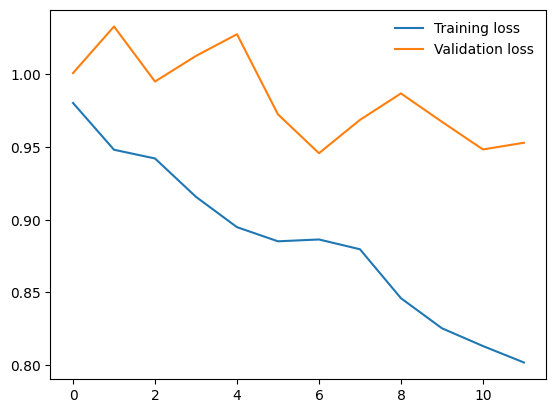

In [32]:
step = 20

#Training loop
train_losses = []
val_losses = []
patience = 5
best_loss = float('inf')
patience_counter = 0
# Restaurer les poids du modèle et l'état de l'optimiseur
model.load_state_dict(torch.load("../../drive/MyDrive/MVA/swin-t_SSL_freeze_20.pth"))
#optimizer.load_state_dict(torch.load('checkpoints/optimizer_epoch_28.pth'))

# Restaurer le numéro de l'époque
start_epoch = 20
for epoch in range(start_epoch, train_config['epochs']):
    # Model Training
    model.train()
    step += 1

    pbar = tqdm(train_loader)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])

    for idx, (img, y) in enumerate(pbar):
        # load target
        y = y.to(device)
        # model output
        y_hat = model(img)

        # loss computation
        loss = criterion(y_hat, y)

        # backward step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get prediction
        _, pred = torch.max(y_hat, dim=1)

        epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
        metrics.add_batch(y, pred)

        pbar.set_description(f"Epoch:{epoch}, Training Loss:{epoch_losses[-100:].mean():.4}")

    mean_loss = epoch_losses.mean()
    train_losses.append(mean_loss)
    train_stats = {
            "train_loss": mean_loss.item(),
            "train_average_accuracy": metrics.get_average_accuracy(),
            "train_mIoU": metrics.get_mIoU(),
            **{
                "train_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
    print(train_stats)

    # Model Validation
    model.eval()
    pbar = tqdm(val_loader)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])

    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)

            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        val_losses.append(mean_loss)
        val_stats = {
            "validation_loss": mean_loss.item(),
            "validation_average_accuracy": metrics.get_average_accuracy(),
            "validation_mIoU": metrics.get_mIoU(),
            **{
                "validation_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
            "train_IoU_" + k: v
            for k, v in metrics.get_IoU().items()
        },
        }

        print(f"Epoch:{epoch}", val_stats)

        # Save model checkpoint every 2 epochs
        if epoch % 2 == 0:
            if epoch == 0:
                continue

            save_weights_path = (
                "checkpoints/" + "-".join(["segmentation", "epoch", str(epoch)]) + ".pth"
            )
            save_opt_path = (
                "checkpoints/" + "-".join(["optimizer", "epoch", str(epoch)]) + ".pth"
            )
            torch.save(model.state_dict(), save_weights_path)
            torch.save(optimizer.state_dict(), save_opt_path)
        val_loss = val_stats["validation_loss"]
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            # Enregistrez les meilleurs poids ici si désiré
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                torch.save(model.state_dict(), '../../drive/MyDrive/MVA/swin-t_SSL_freeze_2_'+str(epoch)+'.pth')
                break
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

In [1]:
def test(model, test_ld):
    model.eval()
    pbar = tqdm(test_ld)

    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)
            all_gts.append(y.cpu().numpy())
            all_preds.append(pred.cpu().numpy())
            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        test_stats = {
            "test_loss": mean_loss.item(),
            "test_average_accuracy": metrics.get_average_accuracy(),
            "test_mIoU": metrics.get_mIoU(),
            **{
                "test_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
        print("Test stats:")

        # Loss
        print(f"  Loss: {test_stats['test_loss']:.4f}")

        # Average accuracy and mIoU
        print(f"  Average Accuracy: {test_stats['test_average_accuracy']:.4f}")
        print(f"  Mean IoU: {test_stats['test_mIoU']:.4f}")

        # Accuracy per class
        print("  Accuracy by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'test_accuracy_pixelclass_{i}']:.4f}")

        # IoU per class
        print("  IoU by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'train_IoU_class_{i}']:.4f}")
        all_preds = np.concatenate(all_preds)
        all_gts = np.concatenate(all_gts)

        # Calculer la matrice de confusion
        conf_matrix = confusion_matrix(all_gts.flatten(), all_preds.flatten(), labels=np.arange(data_config['num_classes']))
        # Normalisation par lignes
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.set(font_scale=0.8)

        # Tracer la matrice de confusion
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(dict_classes_13.values()), yticklabels=list(dict_classes_13.values()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        #sns.set(font_scale=1.2)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    return

In [34]:
torch.save(model.state_dict(), '../../drive/MyDrive/MVA/swin-t_SSL_freeze_60epochs.pth')
# torch.save(model.state_dict(), 'checkpoints/segmentation-epoch-28.pth')

Validation Loss:0.9647: 100%|██████████| 33/33 [00:42<00:00,  1.28s/it]


Test stats:
  Loss: 0.9647
  Average Accuracy: 0.5109
  Mean IoU: 0.3897
  Accuracy by Class:
    Class 0: 0.7905
    Class 1: 0.3527
    Class 2: 0.7256
    Class 3: 0.0562
    Class 4: 0.8261
    Class 5: 0.4787
    Class 6: 0.7762
    Class 7: 0.4789
    Class 8: 0.9207
    Class 9: 0.7281
    Class 10: 0.3054
    Class 11: 0.2032
    Class 12: 0.0000
  IoU by Class:
    Class 0: 0.6265
    Class 1: 0.2230
    Class 2: 0.5945
    Class 3: 0.0556
    Class 4: 0.6647
    Class 5: 0.4112
    Class 6: 0.6733
    Class 7: 0.2984
    Class 8: 0.6196
    Class 9: 0.5073
    Class 10: 0.2439
    Class 11: 0.1474
    Class 12: 0.0000


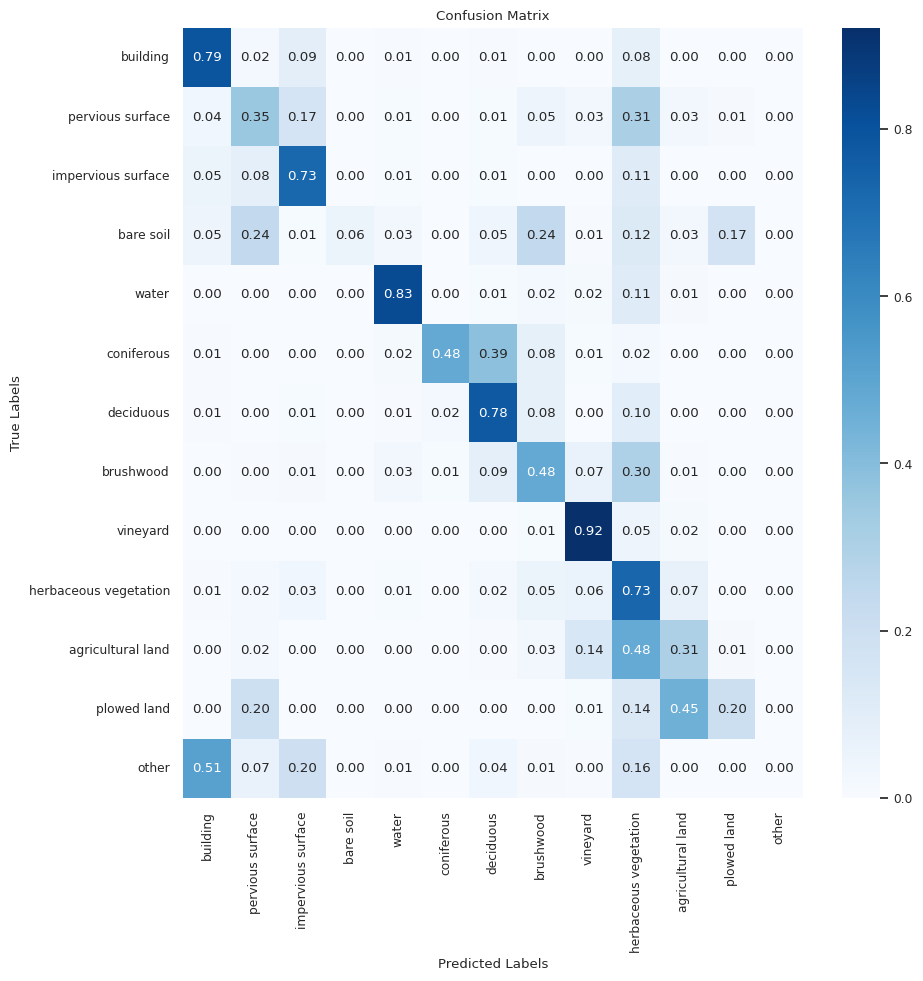

In [35]:
# create a new model's instance
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device)

model = model.to(device)

# load checkpoints weights
model.load_state_dict(torch.load('../../drive/MyDrive/MVA/swin-t_SSL_freeze_60epochs.pth'))#"checkpoints/segmentation-epoch-20.pth"))

test(model, test_loader)